<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data and Glove Model From Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk
nltk.download('popular')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.layers import Embedding

import time

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
!cp gdrive/'My Drive'/bbc-fulltext.zip .
!cp gdrive/'My Drive'/glove.6B.zip .
!unzip bbc-fulltext.zip > out.txt
!rm bbc/README.TXT
!unzip glove.6B.zip

In [3]:
#Read Data
categories = ['business','entertainment','politics','sport','tech']
df = pd.DataFrame([],columns=['category','id','text'])
for cat in categories:
  for file in os.listdir("bbc/"+cat):
      if file.endswith(".txt"):
          filepath = os.path.join("bbc/"+cat, file)
          text = open(filepath,'r', errors='ignore').read()
          s = pd.Series([cat,int(filepath.split('/')[-1][:-4]),text],index=['category','id','text'])
          df = df.append(s,ignore_index=True)

df.head()

,category,id,text
0,business,386,Krispy Kreme shares hit\n\nShares in Krispy Kr...
1,business,190,Consumers drive French economy\n\nFrance's eco...
2,business,439,"German economy rebounds\n\nGermany's economy, ..."
3,business,454,LSE doubts boost bidders' shares\n\nShares in ...
4,business,302,Cactus diet deal for Phytopharm\n\nA slimming ...


In [4]:
'''
#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
'''

'\n#WordCloud\ncat = df[\'category\'].unique()\n\nfor i in range(0,len(cat)):\n    words = \' \'.join(df.loc[df[\'category\']==cat[i], \'text\'])\n\n    wordcloud = WordCloud( \n                          stopwords=STOPWORDS,\n                          background_color=\'white\',\n                          width=800,\n                          height=400\n                ).generate(words)\n    print(cat[i])\n    plt.figure(figsize=(10, 5))\n    plt.imshow(wordcloud)\n    plt.axis(\'off\')\n    plt.show()\n\nwords = \' \'.join(df.loc[:, \'text\'])\n\nwordcloud = WordCloud( \n                      stopwords=STOPWORDS,\n                      background_color=\'white\',\n                      width=800,\n                      height=400\n            ).generate(words)\nprint("ALL Categories:")\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud)\nplt.axis(\'off\')\nplt.show()\n'

## Label Encoder
#### Use inverse_transform at the end after predicting

In [5]:
y = df['category']
X = df.drop(['category','id'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1508       sport
1908        tech
2104        tech
2019        tech
1245    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [6]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [0]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [0]:
#Preprocess both train and test separately
X_train['text'] = preprocess(X_train['text'])
X_test['text'] = preprocess(X_test['text'])

In [0]:
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [0]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [11]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
np.random.seed(123)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 28841 unique tokens.
Shape of data tensor: (1780, 1000)
Shape of label tensor: (1780, 5)


In [0]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [16]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

In [0]:
model_name = "CNN"
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [33]:
stmillis = int(round(time.time() * 1000))
history = model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 16s 12ms/step - loss: 1.5867 - acc: 0.3448 - val_loss: 1.1745 - val_acc: 0.5506

Epoch 00001: val_loss improved from inf to 1.17449, saving model to CNN_weights.01-1.17.hdf5
Epoch 2/50
1424/1424 [==============================] - 16s 11ms/step - loss: 0.7468 - acc: 0.7170 - val_loss: 0.4243 - val_acc: 0.8961

Epoch 00002: val_loss improved from 1.17449 to 0.42427, saving model to CNN_weights.02-0.42.hdf5
Epoch 3/50
1424/1424 [==============================] - 16s 11ms/step - loss: 0.3256 - acc: 0.8926 - val_loss: 0.5455 - val_acc: 0.8146

Epoch 00003: val_loss did not improve from 0.42427
Epoch 4/50
1424/1424 [==============================] - 16s 11ms/step - loss: 0.2276 - acc: 0.9312 - val_loss: 0.1271 - val_acc: 0.9551

Epoch 00004: val_loss improved from 0.42427 to 0.12713, saving model to CNN_weights.04-0.13.hdf5
Epoch 5/50
1424/1424 [==============================] - 16s 11ms/st

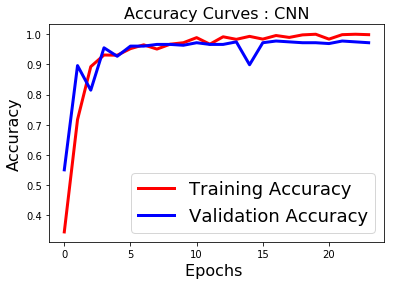

In [34]:
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig.savefig('accuracy_cnn.png')
plt.show()

In [0]:
# Save the trained weights
model.save(model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp CNN.* gdrive/My\ Drive/

## Predict on Test Data

In [37]:
#Tokenize test data and apply model prediction
sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
prediction = model.predict(data)
prediction

Shape of data tensor: (445, 1000)
Shape of label tensor: (1780, 5)


array([[9.9999988e-01, 1.2062247e-09, 1.3278118e-07, 1.3367138e-08,
        2.4016213e-08],
       [1.9103503e-09, 3.6038000e-10, 1.0000000e+00, 1.7263177e-10,
        1.3798496e-10],
       [1.2197917e-13, 1.0000000e+00, 4.2782162e-13, 4.2128448e-13,
        5.2724384e-11],
       ...,
       [3.7501342e-04, 2.1110474e-05, 9.9959105e-01, 6.7955193e-06,
        6.1140636e-06],
       [1.0000000e+00, 3.8850037e-16, 2.8934791e-12, 7.2111913e-14,
        3.5668536e-13],
       [2.4377860e-06, 2.9873661e-07, 9.9999714e-01, 5.3838708e-08,
        1.0643678e-07]], dtype=float32)

In [38]:
count = 0
t = 0
for pred in prediction:
  p = pred.argmax()
  name = le.inverse_transform([p])
  if name == y_test.loc[count]:
    t+=1
  count+=1
    
print('Test Accuracy:',t/count)

Test Accuracy: 0.9820224719101124
